In [1]:
import praw

In [10]:
client_id="zMpqPkDKrXve3gZnk9s6KQ"
client_secret="Y93psrmtpLR8e5xHuxo2HXxJJW3HSA"
password="LeWagonScrapePraw2023"
user_name="SentimentGuy2023"
user_agent="scrapepraw2023"
redirect_uri="http://localhost:8080"

In [11]:
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    password=password,
    user_agent=user_agent,
    redirect_uri=redirect_uri,
    username=user_name,
)
print(reddit.auth.url(scopes=["identity"], state="...", duration="permanent"))

https://www.reddit.com/api/v1/authorize?client_id=zMpqPkDKrXve3gZnk9s6KQ&duration=permanent&redirect_uri=http%3A%2F%2Flocalhost%3A8080&response_type=code&scope=identity&state=...


In [12]:
print(reddit.user.me())

SentimentGuy2023


In [25]:
subreddit = reddit.subreddit("wallstreetbets")
text=[]
score=[]
level=[]
for i in subreddit.hot(limit=5):
    submission=reddit.submission(i)
    print(f"############### submission {i}##########################")
    for top_level_comment in submission.comments:
        try:
            print("New Comment")
            print(top_level_comment.body)
            text.append(top_level_comment.body)
            score.append(top_level_comment.score)
            level.append("top")
            for second_level_comment in top_level_comment.replies:
                print("             -> " + second_level_comment.body)
                text.append(second_level_comment.body)
                score.append(second_level_comment.score)
                level.append("second")
        except AttributeError:
            pass

############### submission 16jn7o3##########################
New Comment
Down $6k today ![img](emote|t5_2th52|4260)
             -> Lol that exactly what I’m down. It’s all good. Lost a couple calls today that are dead but I’m alive with some big plays into next week. Look if we rally then I’m popping champagne and eating lobster. If we crash more then I’m blowing behind Wendy’s for dollar bills. Either way someone is going to have a great time!
New Comment
I want to speak to the manager of the stocks market.
New Comment
Literally traded like dogshit this week
New Comment
You want proof that Disney will go back to all time highs? 1, I hate Disney and what they're doing, but I am still a D+ subscriber and buy Disney crap for my kids. 2, autistic kids love Disney, even into adulthood. Autism has been and continues to be growing exponentially.
             -> >D+ subscriber and buy Disney crap for my kids. 2, autistic kids love Disney, even into adulthood. Autism has been and continues to

In [84]:
import pandas as pd
df_comments = pd.DataFrame.from_dict({"text":text, "score":score, "level":level})
df_comments

,text,score,level
0,Down $6k today ![img](emote|t5_2th52|4260),24,top
1,Lol that exactly what I’m down. It’s all good....,4,second
2,I want to speak to the manager of the stocks m...,20,top
3,Literally traded like dogshit this week,16,top
4,You want proof that Disney will go back to all...,17,top
...,...,...,...
1151,Justus not justice,1,top
1152,Occupy wallstreet,1,top
1153,fuck these banksters.,1,top
1154,SEC over here throwing around wire fraud charg...,1,top


## Below same model that Maria used for the sentiment (1-5), code directly copied from her notebook.

In [29]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import os
import pandas as pd
import numpy as np

tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')



def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1



df_comments['sentiment'] = df_comments['text'].apply(lambda x: sentiment_score(x[:512]))



Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 3.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB ? eta 0:00:000:00:0100:11╸ 1.8/1.8 GB 3.7 MB/s eta 0:00:01╸ 1.8/1.8 GB 3.7 MB/s eta 0:00:01��━━━━━━━━━━━━━━━━━━━━━╸ 1.8/1.8 GB 3.7 MB/s eta 0:00:010m╸ 1.8/1.8 GB 3.7 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0


/home/volter/.pyenv/versions/3.10.6/envs/project_name/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Below we add the emotions from the emotion model as well

In [42]:
from transformers import AutoTokenizer, RobertaForSequenceClassification
##Import model, tokenizer etc.

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")


##Test on a string
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
with torch.no_grad():

    logits = model(**inputs).logits

logits=logits.tolist()[0]
print(logits)
#predicted_class_id = logits.argmax().item()
for i in np.arange(len(logits)):
    print( model.config.id2label[i]  , "  ", logits[i])
      


[-1.2779178619384766, 2.8312392234802246, -0.8164835572242737, -0.3028067946434021]
joy    -1.2779178619384766
optimism    2.8312392234802246
anger    -0.8164835572242737
sadness    -0.3028067946434021


In [46]:
# todo: order wrong

def yield_raw_predictions(comment:str)->str:
    inputs = tokenizer(comment, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    return logits.tolist()[0]

def get_emotion_scores_as_dict(comments:list)->dict:
    joy = []
    optimism = []
    anger = []
    sadness = []
    emotions= [joy, optimism, anger, sadness]
    for comment in comments:
        raw_predictions=yield_raw_predictions(comment[:512])
        for i in np.arange(len(raw_predictions)):
            emotions[i].append(raw_predictions[i])
            
    return {"joy": joy ,"optimism": optimism ,"anger": anger ,"sadness": sadness}

In [50]:
df_emotions = pd.DataFrame.from_dict(get_emotion_scores_as_dict(df_comments["text"]))
df_emotions.head(10)

,joy,optimism,anger,sadness
0,0.508811,-0.677016,-0.677829,1.642364
1,-0.950472,2.656628,0.572796,-1.780320
2,1.086675,-1.092233,0.288888,0.567407
3,2.261142,-1.695377,-1.912354,1.502195
4,2.244317,-0.752381,-1.026989,0.419795
5,-1.027620,2.436725,-0.626746,-0.099384
6,-0.414061,-0.993141,-1.076691,2.842920
7,-0.796988,3.298110,-0.757908,-1.350413
8,3.179287,-1.672738,-0.865828,-0.311691
9,-0.177497,0.461372,1.042939,-0.303562


In [86]:
df_emotions[df_emotions<0]=0
df_comments=pd.concat([df_comments, df_emotions], axis=1)
df_comments.head(10)

,text,score,level,sentiment,joy,optimism,anger,sadness
0,Down $6k today ![img](emote|t5_2th52|4260),24,top,4,0.508811,0.000000,0.000000,1.642364
1,Lol that exactly what I’m down. It’s all good....,4,second,2,0.000000,2.656628,0.572796,0.000000
2,I want to speak to the manager of the stocks m...,20,top,1,1.086675,0.000000,0.288888,0.567407
3,Literally traded like dogshit this week,16,top,1,2.261142,0.000000,0.000000,1.502195
4,You want proof that Disney will go back to all...,17,top,1,2.244317,0.000000,0.000000,0.419795
5,>D+ subscriber and buy Disney crap for my kids...,4,second,2,0.000000,2.436725,0.000000,0.000000
6,"Currently at Disney world with family, recessi...",14,top,4,0.000000,0.000000,0.000000,2.842920
7,Fondling your gf’s giant bazonkas during an of...,14,top,2,0.000000,3.298110,0.000000,0.000000
8,The fuck you mean markets closed on Monday? Ge...,14,top,1,3.179287,0.000000,0.000000,0.000000
9,Former President Trump says he put “outside pr...,12,top,3,0.000000,0.461372,1.042939,0.000000


In [ ]:
sum_joy = df_comments["joy"].sum()
sum_optimism = df_comments["optimism"].sum()
sum_anger = df_comments["anger"].sum()
sum_sadness = df_comments["sadness"].sum()

keys=["joy", "optimism", "anger", "sadness"]
data=[sum_joy,
    sum_optimism,
    sum_anger,
    sum_sadness]

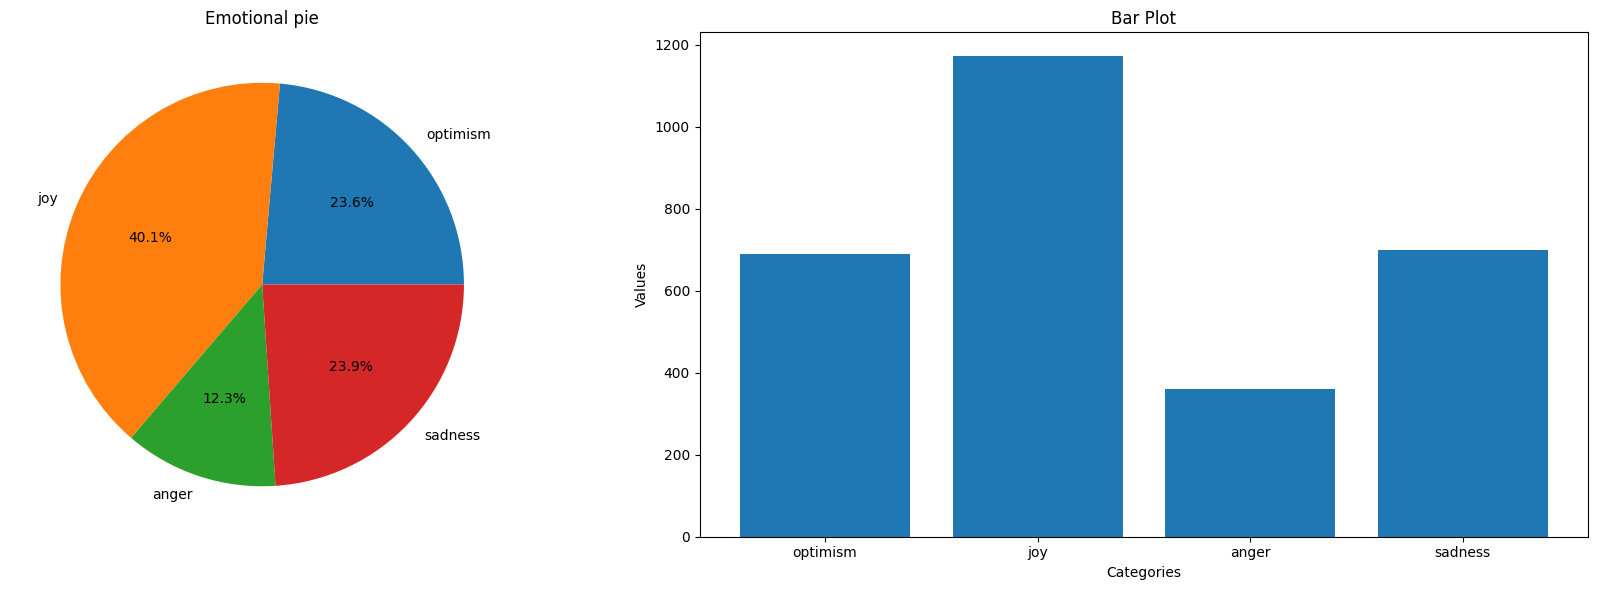

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.pie(data, labels=keys, autopct='%1.1f%%')
plt.title('Emotional pie')
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.bar(keys, data)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot')
plt.tight_layout()  # Automatically adjusts subplot parameters to give specified padding
plt.show()


In [105]:
sents=df_comments.groupby("sentiment").count()["text"]
grouped_df = df_comments.groupby("sentiment")["score"].sum().reset_index()

grouped_df.head(3)

,sentiment,score
0,1,8395
1,2,2377
2,3,1804


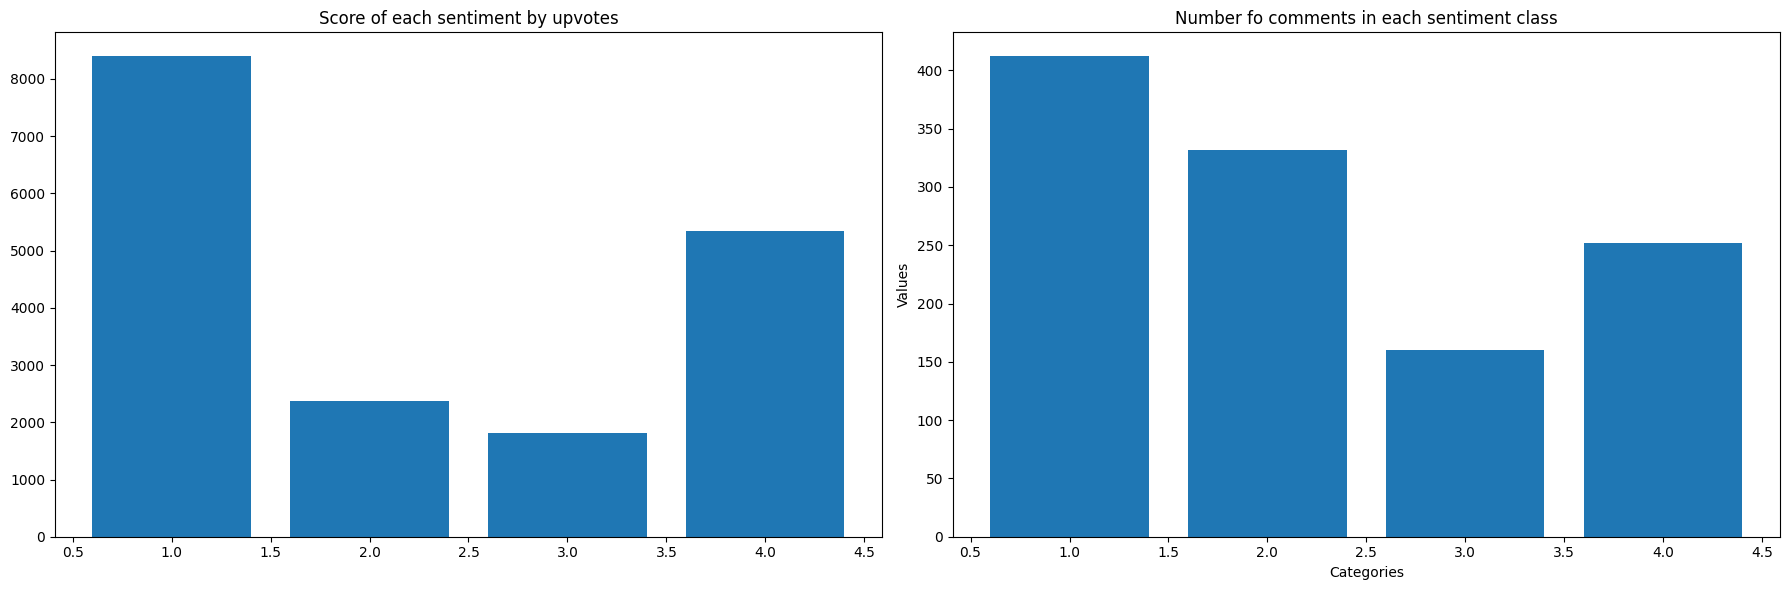

In [107]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.bar(grouped_df["sentiment"], grouped_df["score"])
plt.title('Score of each sentiment by upvotes')
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.bar(grouped_df["sentiment"], sents)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Number fo comments in each sentiment class')
plt.tight_layout()  # Automatically adjusts subplot parameters to give specified padding
plt.show()